In [89]:
!pip install p3_data

In [90]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [91]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [140]:
# Load result files from P3 Test Driver
src_files = []

src_files += ['../../../no_netty_comparison/latest_master_14tests/p3_test_driver/results1/*.json']
src_files += ['../../../no_netty_comparison/low_cpu_full_14test_rerun/low_cpu_full_14test_rerun/p3_test_driver/results1/*.json']
#src_files += ['../../../no_netty_comparison/low_cpu_full_14test_rerun/low_cpu_full_14test_rerun/p3_test_driver/results1/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 45 files...


In [141]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '0.6.0-2361.f273314-SNAPSHOT'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [142]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [143]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [144]:
# Show list of columns
clean_df.columns.values

array(['ansible', 'ansible_vars', 'aws-ec2', 'build', 'command_timed_out',
       'docker', 'driver', 'elapsed_sec', 'error', 'errors', 'exit_code',
       'git_commit', 'kubernetes', 'localWorker', 'max_test_attempts',
       'noop', 'numWorkers', 'omb_results', 'omb_workers', 'output',
       'print_output', 'record_utc', 'record_uuid', 'result_filename',
       'run_as_test', 'sequence_in_test_batch', 'size_of_test_batch',
       'ssh_host', 'ssh_identity_file', 'ssh_user', 'status_html',
       'tarball', 'terraform', 'terraform_show', 'test', 'test_attempt',
       'test_batch_uuid', 'test_desc', 'test_driver_log_filename',
       'test_driver_version', 'test_uuid', 'undeploy', 'utc_begin',
       'utc_end', 'loaded_filename', 'driverName',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic', 'testDurationMinutes', '

In [145]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'pravegaVersion',
]

In [146]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'utc_begin',    
]

In [147]:
cols = param_cols + output_cols

In [148]:
# View most recent results
clean_df[cols].tail(3).T

test_uuid,6a3faad8-2a42-4280-b145-7aad5fb43c04,11315c88-e85b-43dc-b7c4-efdf41917a92,0cda8c0f-c655-4b87-a6a3-db14f803af3c
numWorkloadWorkers,2,2,2
topics,1,1,1
partitionsPerTopic,16,16,16
producersPerTopic,1,1,1
subscriptionsPerTopic,1,1,1
consumerPerSubscription,16,16,16
testDurationMinutes,1,1,1
keyDistributor,NO_KEY,NO_KEY,NO_KEY
git_commit,c8aee8e,a5a5da2,063f2f6
pravegaVersion,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_latest_master


In [149]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [150]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [151]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['pravegaVersion']).size()

pravegaVersion
0.8.0-2508.30406cf_latest_master    30
0.8.0-2508.30406cf_low_cpu          15
dtype: int64

In [152]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
  #  driverName='Pravega',
  #  pravegaVersion='0.8.0-2508.30406cf',
#     pravegaVersion='0.6.0-2386.23b7340',
   # numWorkloadWorkers=2, 
    topics=1,
    testDurationMinutes=1,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

45

In [153]:
def latency_vs_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Publish Throughput (MB/s)'
    return result_df

In [154]:
def plot_latency_vs_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    plot_df = latency_vs_throughput_table(df)
    title = 'Message Size %d' % (messageSize)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [155]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=1,
    partitionsPerTopic=16,
)

In [156]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid,58b81404-4814-4cc6-99ea-d510788d2335,58b81404-4814-4cc6-99ea-d510788d2335,11d9c3d4-9c76-48db-897f-0af4ea478725
ansible_vars,"{'bookkeeperVersion': '4.9.2', 'pravegaContain...","{'bookkeeperVersion': '4.9.2', 'pravegaContain...","{'bookkeeperVersion': '4.9.2', 'pravegaContain..."
elapsed_sec,129.309,129.309,130.586
git_commit,a7e3cc3,a7e3cc3,78344c6
omb_results,"{'aggregatedEndToEndLatency50pct': 4.0, 'aggre...","{'aggregatedEndToEndLatency50pct': 4.0, 'aggre...","{'aggregatedEndToEndLatency50pct': 4.0, 'aggre..."
output,09:34:17.218 [main] INFO io.openmessaging.ben...,09:34:17.218 [main] INFO io.openmessaging.ben...,17:33:40.585 [main] INFO io.openmessaging.ben...
record_utc,2020-04-23T09:36:25.872600,2020-04-23T09:36:25.872600,2020-04-23T17:35:50.496099
record_uuid,cff438e3-91d9-4cc7-be45-7a4a6bba9133,cff438e3-91d9-4cc7-be45-7a4a6bba9133,cddfad8b-3e11-4849-8d01-b905adf82f0a
sequence_in_test_batch,2,2,1
size_of_test_batch,14,14,4
terraform_show,"{'format_version': '0.1', 'terraform_version':...","{'format_version': '0.1', 'terraform_version':...","{'format_version': '0.1', 'terraform_version':..."


In [157]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,58b81404-4814-4cc6-99ea-d510788d2335,58b81404-4814-4cc6-99ea-d510788d2335,11d9c3d4-9c76-48db-897f-0af4ea478725
numWorkloadWorkers,2,2,2
topics,1,1,1
partitionsPerTopic,16,16,16
producersPerTopic,1,1,1
subscriptionsPerTopic,1,1,1
consumerPerSubscription,16,16,16
testDurationMinutes,1,1,1
keyDistributor,NO_KEY,NO_KEY,NO_KEY
git_commit,a7e3cc3,a7e3cc3,78344c6
pravegaVersion,0.8.0-2508.30406cf_low_cpu,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_latest_master


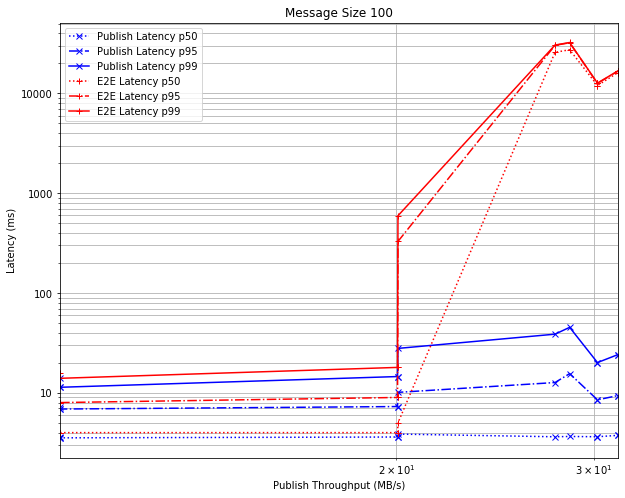

In [158]:
plot_latency_vs_throughput(filt_100_df)

In [159]:
latency_vs_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
10.030169,3.597,7.291,13.952,4.000,8.000,16.000,11d9c3d4-9c76-48db-897f-0af4ea478725
10.032793,3.547,6.891,11.382,4.000,8.000,14.000,58b81404-4814-4cc6-99ea-d510788d2335
10.032793,3.547,6.891,11.382,4.000,8.000,14.000,58b81404-4814-4cc6-99ea-d510788d2335
20.053421,3.615,7.297,14.578,4.000,9.000,18.000,f85321a4-4456-42cc-9e0f-3476b6b24a96
20.053421,3.615,7.297,14.578,4.000,9.000,18.000,f85321a4-4456-42cc-9e0f-3476b6b24a96
20.071018,3.866,10.123,27.904,5.000,329.001,595.003,e3697da9-8fba-497b-9708-86ee23508b6a
27.707679,3.635,12.697,38.743,25766.015,30291.071,30478.079,d7898bf6-2639-4736-9b40-d0dc2f246df9
28.551887,3.661,15.594,45.361,27367.039,32130.047,32343.039,75110be1-8b47-4744-b444-50075ab5692f
30.229811,3.637,8.517,20.126,11991.039,12600.063,12682.047,a61e660d-c60b-4e15-a0e9-aeb3841a3ac2


## Message Size 10 KB

In [160]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    partitionsPerTopic=16
)

In [161]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,26092051-c341-41a5-962b-908e7c9266d1,26092051-c341-41a5-962b-908e7c9266d1,9309479a-1e45-4977-b618-e05faadc2cae,9309479a-1e45-4977-b618-e05faadc2cae,df45fad2-8262-415f-9ba6-bbe4cf10292b,df45fad2-8262-415f-9ba6-bbe4cf10292b,a0d445ac-eca6-49a6-82a6-3737a4dc8227,6a3faad8-2a42-4280-b145-7aad5fb43c04,11315c88-e85b-43dc-b7c4-efdf41917a92,0cda8c0f-c655-4b87-a6a3-db14f803af3c
numWorkloadWorkers,2,2,2,2,2,2,2,2,2,2
topics,1,1,1,1,1,1,1,1,1,1
partitionsPerTopic,16,16,16,16,16,16,16,16,16,16
producersPerTopic,1,1,1,1,1,1,1,1,1,1
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,16,16,16,16,16,16,16,16,16,16
testDurationMinutes,1,1,1,1,1,1,1,1,1,1
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,a7e3cc3,a7e3cc3,1b7182c,1b7182c,ca5583e,ca5583e,4204e30,c8aee8e,a5a5da2,063f2f6
pravegaVersion,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_low_cpu,0.8.0-2508.30406cf_low_cpu,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_low_cpu,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_latest_master,0.8.0-2508.30406cf_latest_master


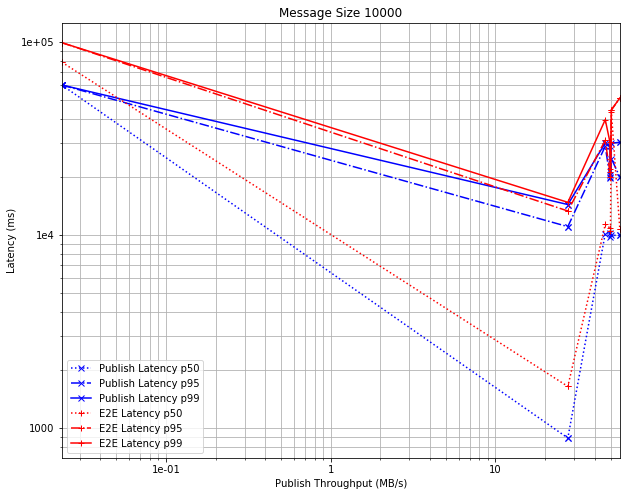

In [162]:
plot_latency_vs_throughput(filt_10000_df)

In [163]:
latency_vs_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.023331,60000.255,60000.255,60000.255,78788.095,99401.215,99401.215,9309479a-1e45-4977-b618-e05faadc2cae
0.023331,60000.255,60000.255,60000.255,78788.095,99401.215,99401.215,9309479a-1e45-4977-b618-e05faadc2cae
27.508816,888.675,11073.151,14410.111,1645.007,13343.039,14795.007,df45fad2-8262-415f-9ba6-bbe4cf10292b
27.508816,888.675,11073.151,14410.111,1645.007,13343.039,14795.007,df45fad2-8262-415f-9ba6-bbe4cf10292b
46.409418,10198.783,28886.399,30024.703,11368.063,31040.127,39675.135,a0d445ac-eca6-49a6-82a6-3737a4dc8227
49.481406,10315.519,20121.983,28837.247,10909.055,21274.111,30525.055,11315c88-e85b-43dc-b7c4-efdf41917a92
49.913258,9785.983,19730.687,20386.303,10450.047,19934.079,21928.063,0cda8c0f-c655-4b87-a6a3-db14f803af3c
50.540260,9981.055,24953.215,29987.711,43380.223,44542.207,44582.143,6a3faad8-2a42-4280-b145-7aad5fb43c04
56.890474,9977.279,20007.295,30280.831,10772.031,51219.199,51408.127,26092051-c341-41a5-962b-908e7c9266d1


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [164]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

6

In [165]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

,partitionsPerTopic,consumerPerSubscription,git_commit,pravegaVersion,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMs50Pct,publishLatencyMs99Pct,endToEndLatencyMs50Pct,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,,
668d63ab-aa1b-4781-ac4d-dfaba465f0e4,16,16,a7e3cc3,0.8.0-2508.30406cf_low_cpu,315364.073785,31.536407,3.757,24.214,16184.063,16845.055,2020-04-23 09:47:21.760110+00:00
668d63ab-aa1b-4781-ac4d-dfaba465f0e4,16,16,a7e3cc3,0.8.0-2508.30406cf_latest_master,315364.073785,31.536407,3.757,24.214,16184.063,16845.055,2020-04-23 09:47:21.760110+00:00
75110be1-8b47-4744-b444-50075ab5692f,16,16,78344c6,0.8.0-2508.30406cf_latest_master,285518.866808,28.551887,3.661,45.361,27367.039,32343.039,2020-04-23 17:40:16.971082+00:00
c593eeca-816a-4582-8afb-474a59ae9ddd,1,1,a7e3cc3,0.8.0-2508.30406cf_low_cpu,712610.875922,71.261088,103.904,168.360,36658.175,47866.111,2020-04-23 09:45:11.483422+00:00
c593eeca-816a-4582-8afb-474a59ae9ddd,1,1,a7e3cc3,0.8.0-2508.30406cf_latest_master,712610.875922,71.261088,103.904,168.360,36658.175,47866.111,2020-04-23 09:45:11.483422+00:00
4dd21a7e-5774-4f85-a67c-22979236e54d,1,1,489700b,0.8.0-2508.30406cf_latest_master,632410.307745,63.241031,118.233,174.632,46486.015,61835.007,2020-04-23 17:21:39.509253+00:00


# Analyze Latency Distribution

In [166]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

'668d63ab-aa1b-4781-ac4d-dfaba465f0e4'

In [167]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

In [168]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [169]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

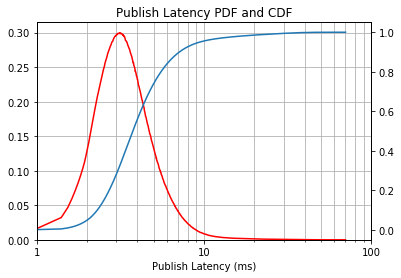

In [170]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [171]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

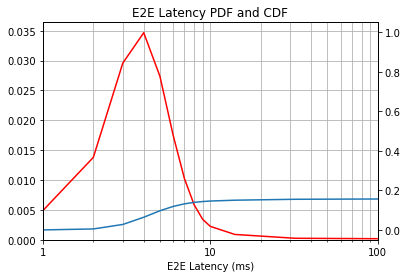

In [172]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

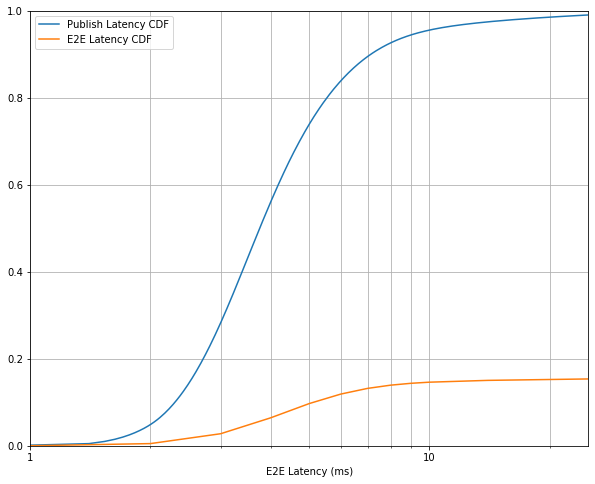

In [173]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [181]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    driverName='Pravega',
    numWorkloadWorkers=2, 
    topics=1,
    testDurationMinutes=1,
    size_of_test_batch=(2,1000), # between
    aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=100,
    producersPerTopic=1,
    partitionsPerTopic=1,    
)
len(filt_df)
filt_df.iloc[0].pravegaVersion


'0.8.0-2508.30406cf_low_cpu'

In [182]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.8.0-2508.30406cf_latest_master',
)
len(filt1_df)

8

In [183]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.8.0-2508.30406cf_low_cpu',
)
len(filt2_df)

4

In [184]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

,git_commit,pravegaVersion
test_uuid,,
58b81404-4814-4cc6-99ea-d510788d2335,a7e3cc3,0.8.0-2508.30406cf_latest_master
11d9c3d4-9c76-48db-897f-0af4ea478725,78344c6,0.8.0-2508.30406cf_latest_master
58b81404-4814-4cc6-99ea-d510788d2335,a7e3cc3,0.8.0-2508.30406cf_low_cpu


In [185]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

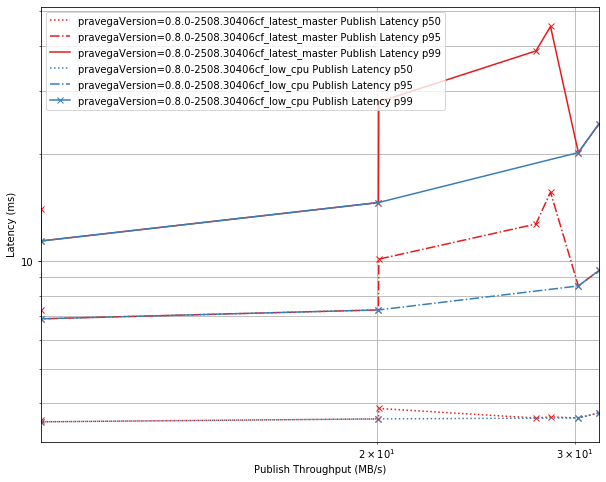

In [186]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='Publish')

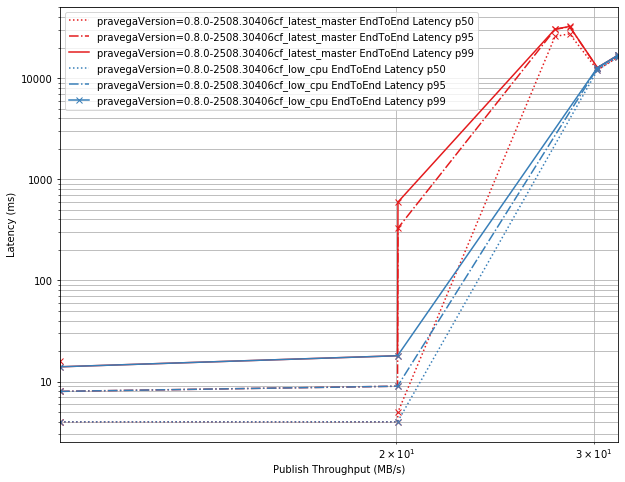

In [187]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='EndToEnd')